## 用于测试各种核方法或者其他计算propensity scores的方法


In [1]:
from sklearn import linear_model
from scipy.sparse import coo_matrix
from scipy.stats import ttest_rel, binom
from scipy.stats import chi2
import numpy as np
from math import log
import sys

import sklearn.metrics.pairwise
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

/home/yang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/home/yang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_X=True, 

In [2]:
filename = "data/data1_movie.txt"
param_reg = 1.0
param_thresh = 100000.0

word_docs = {}
docs_word = []
vocab = {}
l = 0
iter_num = 500

for line in open(filename):
    if l >= iter_num:
        break
    tokens = line.strip().split()
    docs_word.append(tokens[1 : ])
    for word in set(tokens[1 : ]):
        if word not in vocab:
            vocab[word] = len(vocab)
        if word not in word_docs:
            word_docs[word] = []
        word_docs[word].append(l)
    
    l += 1
    
L = l
V = len(vocab)

print("%d documents, %d distinct word types" % (L, V))

500 documents, 6927 distinct word types


In [3]:
vocab

{'see': 0,
 'effects': 1,
 'felt': 2,
 'when': 3,
 'story': 4,
 'more': 5,
 'part': 6,
 'acting': 7,
 'love': 8,
 'will': 9,
 'll': 10,
 'saw': 11,
 'great': 12,
 'movies': 13,
 'franchise': 14,
 'admit': 15,
 've': 16,
 'superhero': 17,
 'raised': 18,
 'fast': 19,
 'known': 20,
 'booked': 21,
 'eat': 22,
 'gritty': 23,
 'faces': 24,
 'not': 25,
 'serkis': 26,
 'well': 27,
 'and': 28,
 'throughout': 29,
 'isn': 30,
 'here': 31,
 'you': 32,
 'again': 33,
 'the': 34,
 'but': 35,
 'music': 36,
 'that': 37,
 'words': 38,
 'away': 39,
 'this': 40,
 'plenty': 41,
 'exciting': 42,
 'hopefully': 43,
 'blew': 44,
 'fantastic': 45,
 'me': 46,
 'even': 47,
 'an': 48,
 're': 49,
 'andy': 50,
 'if': 51,
 'film': 52,
 'times': 53,
 'fan': 54,
 'somehow': 55,
 'had': 56,
 'pattinson': 57,
 'of': 58,
 'surprisingly': 59,
 'play': 60,
 'was': 61,
 'my': 62,
 'awesome': 63,
 'paced': 64,
 'he': 65,
 '10': 66,
 'eyebrow': 67,
 'cast': 68,
 'to': 69,
 'renewed': 70,
 'few': 71,
 'genuinely': 72,
 'already

In [4]:
word_docs

{'see': [0,
  1,
  7,
  9,
  11,
  12,
  27,
  29,
  30,
  34,
  40,
  43,
  49,
  51,
  52,
  55,
  56,
  59,
  63,
  64,
  66,
  69,
  93,
  99,
  104,
  110,
  115,
  116,
  117,
  120,
  124,
  130,
  138,
  147,
  149,
  151,
  156,
  158,
  162,
  165,
  167,
  171,
  182,
  189,
  195,
  200,
  208,
  213,
  215,
  217,
  219,
  225,
  230,
  234,
  242,
  246,
  253,
  256,
  259,
  261,
  262,
  269,
  270,
  274,
  276,
  281,
  288,
  291,
  294,
  298,
  300,
  304,
  306,
  307,
  308,
  315,
  319,
  320,
  325,
  326,
  327,
  332,
  349,
  350,
  352,
  357,
  360,
  362,
  365,
  368,
  374,
  375,
  384,
  385,
  387,
  389,
  390,
  392,
  400,
  402,
  408,
  409,
  414,
  417,
  420,
  428,
  437,
  439,
  443,
  448,
  449,
  457,
  460,
  465,
  467,
  471,
  484,
  487,
  488,
  494],
 'effects': [0, 111, 115, 124, 182, 235, 391, 401, 415, 465],
 'felt': [0,
  1,
  12,
  16,
  17,
  22,
  29,
  50,
  52,
  54,
  70,
  104,
  112,
  125,
  130,
  147,
  154,
  15

In [5]:
treatment = "great"

rows = []
cols = []
values = []
y = []

for line in range(iter_num):

    contains_treatment = 0
    for word in docs_word[line]:
        if word == treatment:
            contains_treatment = 1
        else:
            rows.append(line)
            cols.append(vocab[word])
            values.append(1.0)
    y.append(contains_treatment)
    
x = coo_matrix((values, (rows, cols)), shape = (iter_num, V)).toarray()
print(x.shape)

(500, 6927)


In [6]:
class Model(object):
    def __init__(self, kernel = "linear", C = 1.0, gamma = 'auto', degree = 3, coef0 = 0., anova = False, percentile = 10):
        self.kernel = kernel
        self.C = C
        self.gamma = gamma
        self.degree = degree
        self.coef0 = coef0
        self.anova = anova
        self.percentile = percentile
        if anova:
            self.model = Pipeline(
                [
                    ("anova", SelectPercentile()),
                    ("scaler", StandardScaler()),
                    ("svc", svm.SVC(kernel = self.kernel, C = self.C, gamma = self.gamma, 
                                    degree = self.degree, coef0 = self.coef0, probability = True))
                ]
            )
        else:
            self.model = svm.SVC(kernel = self.kernel, C = self.C, gamma = self.gamma, 
                                 degree = self.degree, coef0 = self.coef0, probability = True)
        
    def fit(self, x, y):
        self.model.fit(x, y)
        
    def predict_proba(self, x):
        return self.model.predict_proba(x)

In [7]:
def plt_hist(scores, y, coef = np.zeros((4, 2)), output = False):
    plt.figure(figsize=(15,7))
    plt.hist(scores[[i for i, x in zip(range(len(y)), y) if x == 0]], bins=50, label='Negatives')
    plt.hist(scores[[i for i, x in zip(range(len(y)), y) if x == 1]], bins=50, label='Positives', alpha = 0.7, color='r')
    plt.xlabel('Probability of being Positive Class', fontsize=25)
    plt.ylabel('Number of records in each bucket', fontsize=25)
    plt.legend(fontsize=15)
    plt.tick_params(axis='both', labelsize=25, pad=5)
    if output:
        coef_str = '_'.join('_'.join(str(int(x)) for x in line) for line in coef)
        plt.title(coef_str)
        imagepath = 'images/coef' + coef_str + '.png'
        plt.savefig(imagepath)
    else:
        plt.show() 

## Logistic Regression

/home/yang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


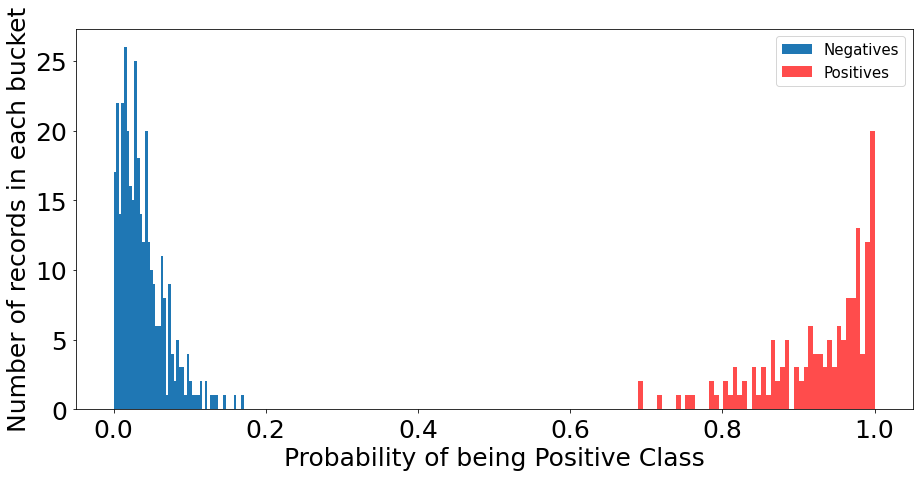

In [8]:
initial_model = linear_model.LogisticRegression()
initial_model.fit(x, y)
initial_scores = initial_model.predict_proba(x)[ : , 1]
plt_hist(initial_scores, y)

## Gaussian kernel

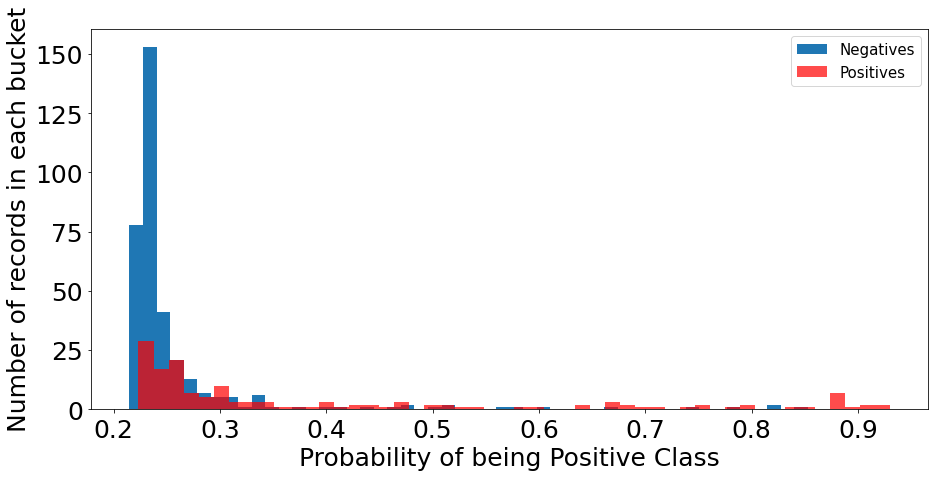

In [9]:
model = Model(kernel = 'rbf')
model.fit(x, y)
scores = model.predict_proba(x)[ : , 1]
plt_hist(scores, y)

## Polynomial kernel (default: degree = 3)

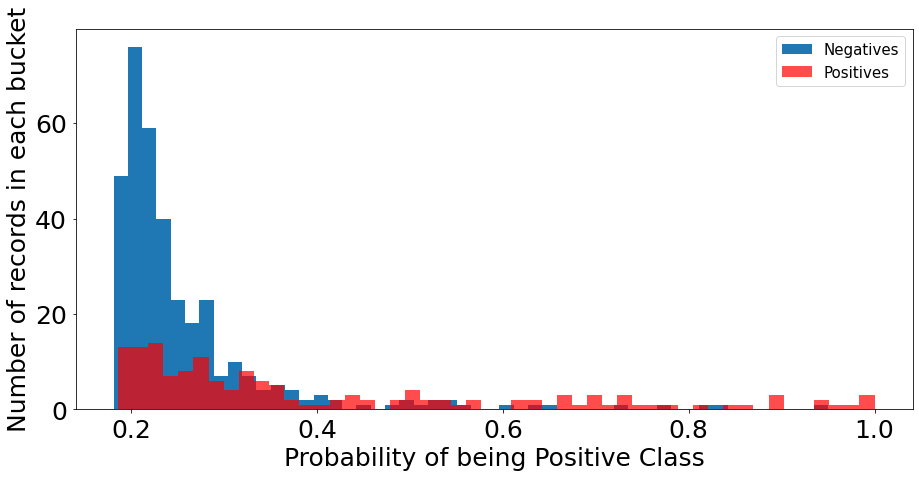

In [10]:
model = Model(kernel = 'poly', degree = 1)
model.fit(x, y)
scores = model.predict_proba(x)[ : , 1]
plt_hist(scores, y)

## Sigmoid kernel

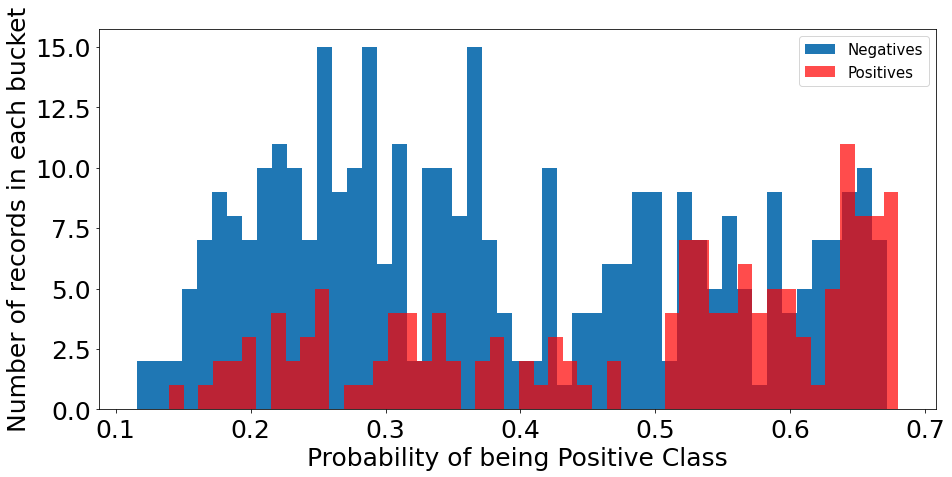

In [11]:
model = Model(kernel = 'sigmoid', gamma = 0.001, coef0 = 10)
model.fit(x, y)
scores = model.predict_proba(x)[ : , 1]
plt_hist(scores, y)

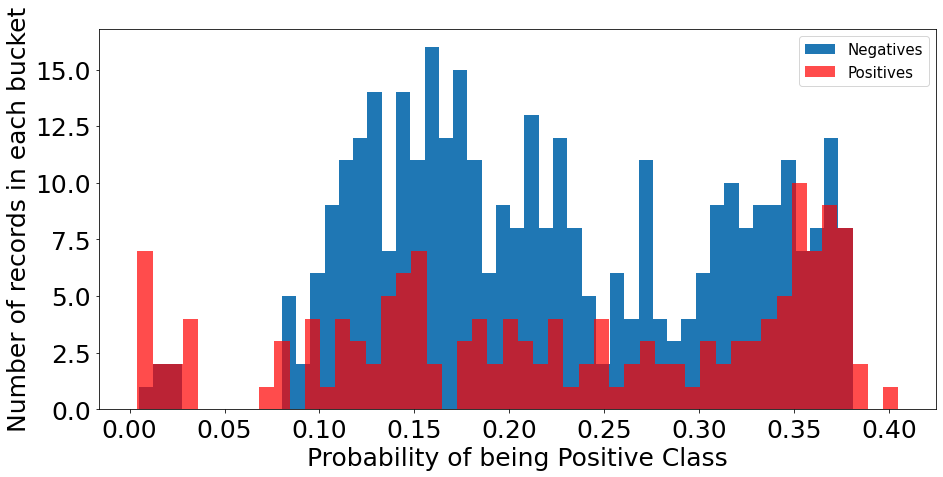

In [12]:
model = Model(kernel = 'sigmoid', gamma = 0.0009)
model.fit(x, y)
scores = model.predict_proba(x)[ : , 1]
plt_hist(scores, y)

## Linear kernel

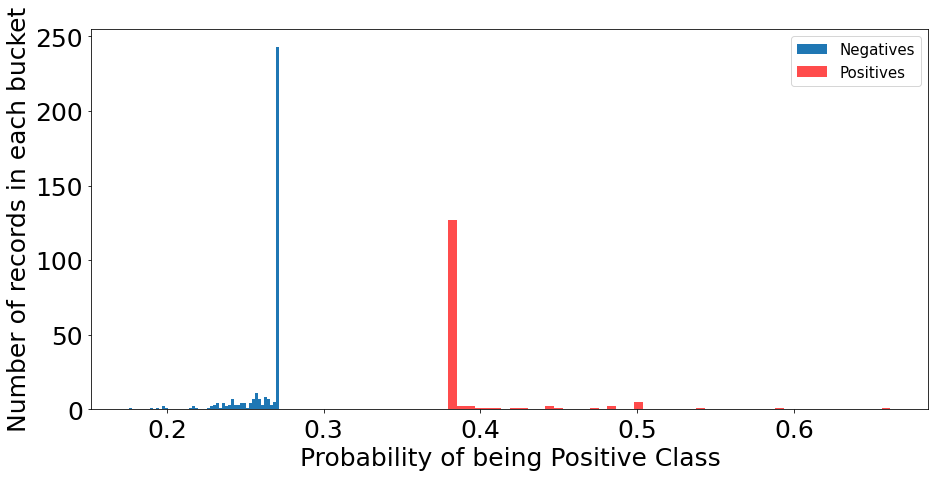

In [13]:
model = Model()
model.fit(x, y)
scores = model.predict_proba(x)[ : , 1]
plt_hist(scores, y)

## Gaussian kernel with LogisticRegression

(500, 6927)


/home/yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/yang/anaconda3/lib/python3.7/site-packages/skl

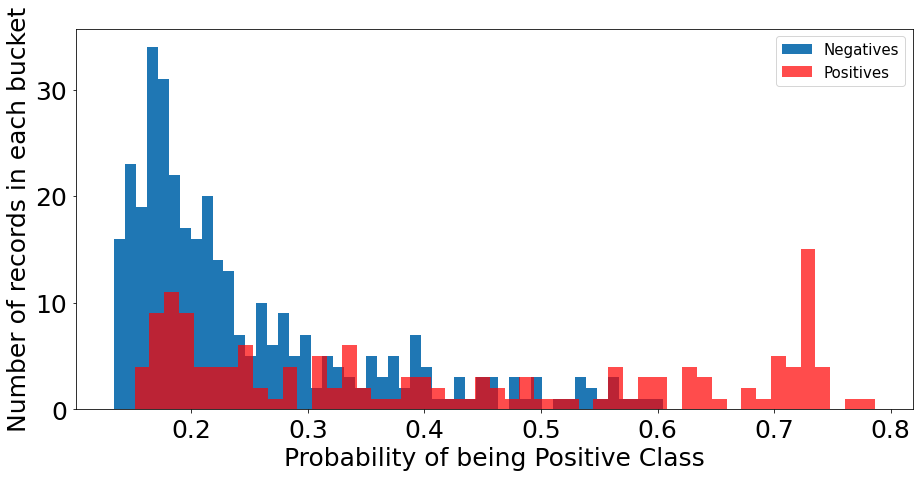

In [14]:
model = linear_model.LogisticRegression(C=1)
print(x.shape)
new_x = sklearn.metrics.pairwise.rbf_kernel(x, x, gamma = 0.0015)
model.fit(new_x, y)
scores = model.predict_proba(new_x)[ : , 1]
plt_hist(scores, y)

## Polynomial kernel with LogisticRegression

/home/yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/yang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


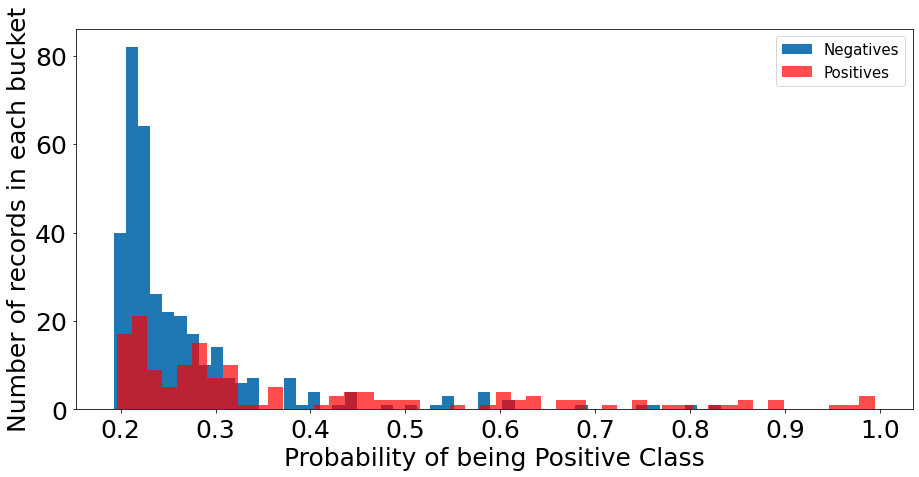

In [15]:
model = linear_model.LogisticRegression(C=0.1)
x_ = sklearn.metrics.pairwise.polynomial_kernel(x, x, degree = 3)
model.fit(x_, y)
scores = model.predict_proba(x_)[ : , 1]
plt_hist(scores, y)

## Linear kernel with LogisticRegression

/home/yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/yang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/yang/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


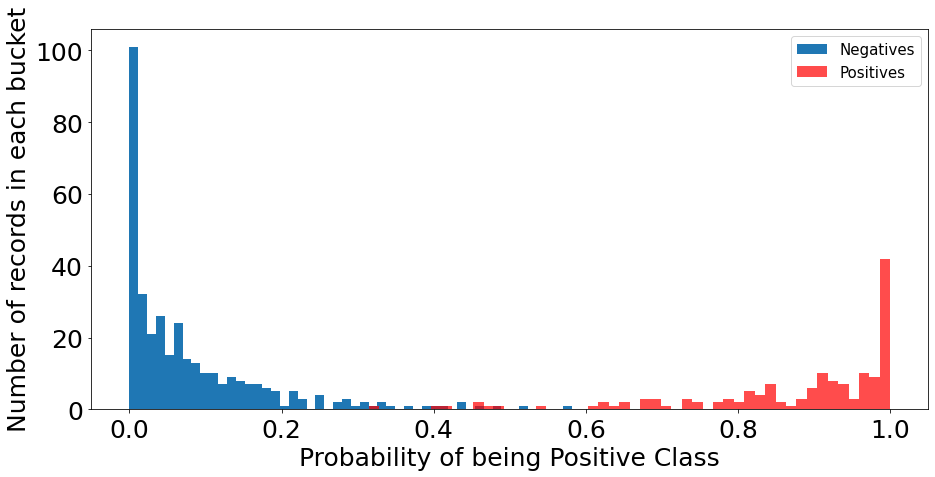

In [16]:
model = linear_model.LogisticRegression(C=1)
x_ = sklearn.metrics.pairwise.linear_kernel(x, x)
model.fit(x_, y)
scores = model.predict_proba(x_)[ : , 1]
plt_hist(scores, y)

## Sigmoid kernel with LogisticRegression

/home/yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/yang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


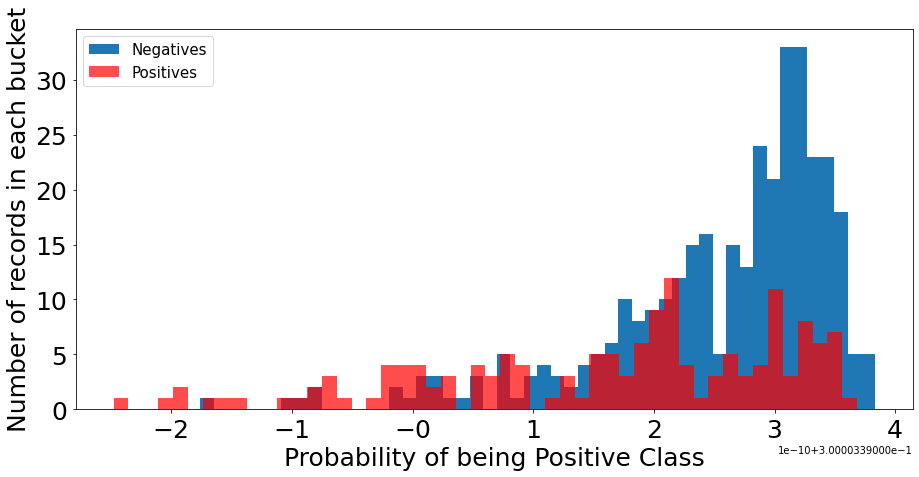

In [17]:
model = linear_model.LogisticRegression(C=1)
x_ = sklearn.metrics.pairwise.sigmoid_kernel(x, x, gamma = 0.001, coef0 = 10)
model.fit(x_, y)
scores = model.predict_proba(x_)[ : , 1]
plt_hist(scores, y)

## Linear combination of kernels

In [18]:
model = linear_model.LogisticRegression(C=1)
x_rbf = sklearn.metrics.pairwise.rbf_kernel(x, x, gamma = 0.0015)
x_linear = sklearn.metrics.pairwise.linear_kernel(x, x)
x_poly = sklearn.metrics.pairwise.polynomial_kernel(x, x, degree = 2)
x_sigmoid = sklearn.metrics.pairwise.sigmoid_kernel(x, x, gamma = 0.0001)

/home/yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/yang/anaconda3/lib/python3.7/site-packages/skl

/home/yang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/yang/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


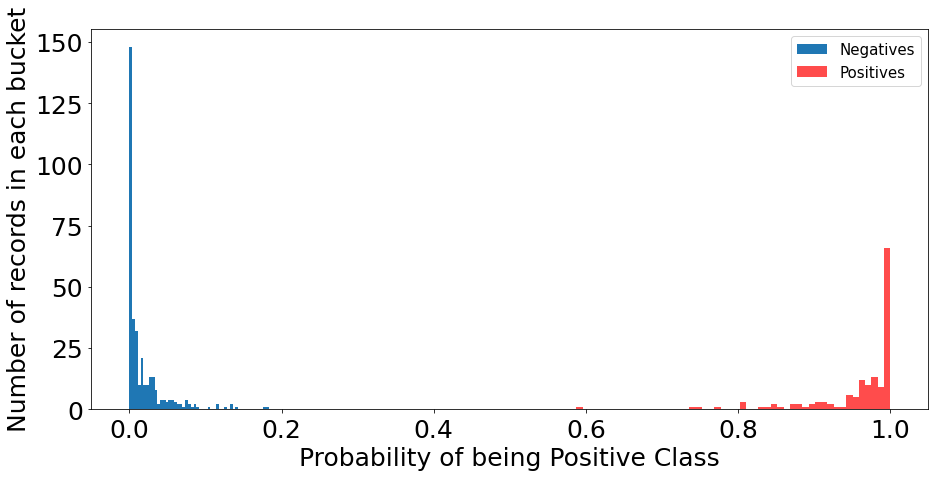

In [19]:
a = 1
b = 1
c = 1
d = 1
x_new = a * x_rbf + b * x_linear + c * x_poly + d * x_sigmoid
model.fit(x_new, y)
scores = model.predict_proba(x_new)[ : , 1]
plt_hist(scores, y)

/home/yang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


FileNotFoundError: [Errno 2] No such file or directory: 'images/coef0_0_0_0_0_0_0_0.png'

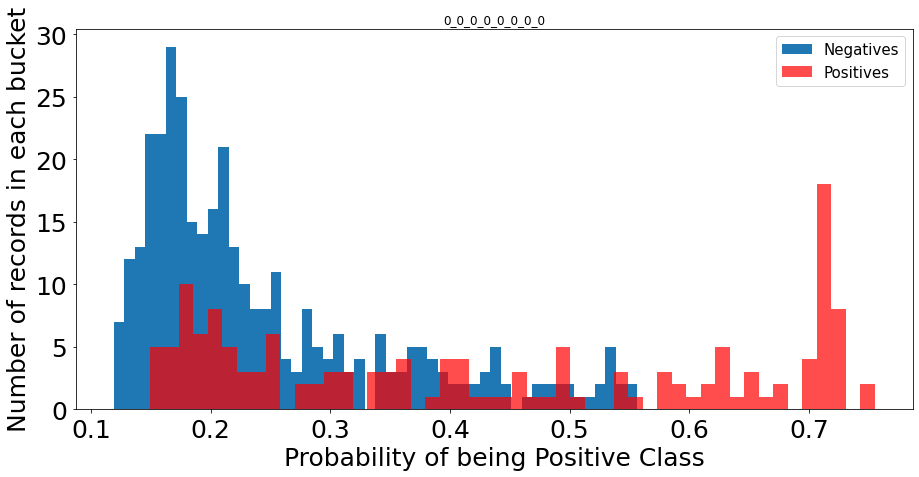

In [20]:
x_new = a * x_rbf ** 1.5
model.fit(x_new, y)
scores = model.predict_proba(x_new)[ : , 1]
plt_hist(scores, y, output = True)

In [ ]:
# for a in range(1, 4):
#     for b in range(1, 4):
#         for c in range(1, 4):
#             for d in range(1, 4):
#                 for e in range(1, 4):
#                     for f in range(1, 4):
#                         for g in range(1, 4):
#                             for h in range(1, 4):
#                                 x_new = a * x_rbf ** b + c * x_linear ** d + e * x_poly ** f + g * x_sigmoid ** h
#                                 model.fit(x_new, y)
#                                 scores = model.predict_proba(x_new)[ : , 1]
#                                 coef = np.array([a, b, c, d, e, f, g, h]).reshape(4, 2)
#                                 plt_hist(scores, y, coef = coef, output = True)

In [21]:
import sklearn.metrics